In [1]:
import os
import sys
sys.path.append("../../../..")
from nebula.evaluation import read_cv_data_splits
from nebula.evaluation.roc import get_model_rocs, allign_metrics
from nebula.misc.plots import plot_roc_curves
from nebula.models.attention import TransformerEncoderChunks
from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")

In [2]:
model_config = {
    "vocab_size": 50002,
    "maxlen": 512,
    "chunk_size": 64,
    "dModel": 64,
    "nHeads": 8,
    "dHidden": 256,
    "nLayers": 2,
    "numClasses": 1,
    "hiddenNeurons": [
        64
    ],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False
}

data_splits = read_cv_data_splits(".")

metrics = get_model_rocs(
    run_types=["adamw", "adam"],
    model_class=TransformerEncoderChunks,
    model_config=model_config,
    data_splits=data_splits,
    logfile=[x for x in os.listdir() if x.endswith(".log")][0],
    verbose=True
)

base_fpr, tprs_mean, tprs_std = allign_metrics(metrics)

Model files:
	adamw: ['.\\training_files\\1677335344-model.torch', '.\\training_files\\1677335757-model.torch', '.\\training_files\\1677336156-model.torch']
	adam: ['.\\training_files\\1677336562-model.torch', '.\\training_files\\1677336955-model.torch', '.\\training_files\\1677337362-model.torch']

Evaluating adamw_split_0 | Size: 5397377...


100%|██████████| 397/397 [00:08<00:00, 47.29it/s]


Evaluating adamw_split_1 | Size: 5397377...


100%|██████████| 397/397 [00:08<00:00, 46.50it/s]


Evaluating adamw_split_2 | Size: 5397377...


100%|██████████| 397/397 [00:08<00:00, 45.10it/s]


Evaluating adam_split_0 | Size: 5397377...


100%|██████████| 397/397 [00:08<00:00, 44.49it/s]


Evaluating adam_split_1 | Size: 5397377...


100%|██████████| 397/397 [00:08<00:00, 44.67it/s]


Evaluating adam_split_2 | Size: 5397377...


100%|██████████| 397/397 [00:08<00:00, 46.97it/s]


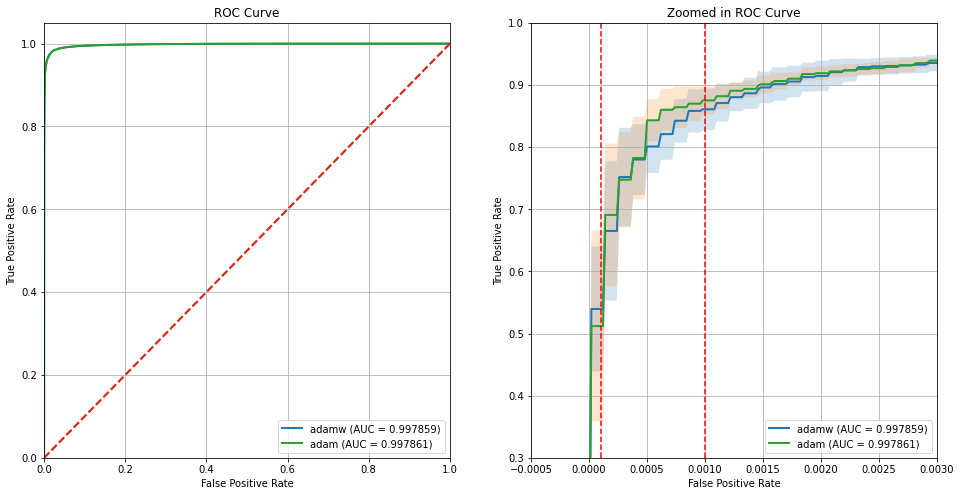

In [3]:
for i, model_type in enumerate(tprs_mean.keys()):
    if i == 0:
        axs = None
    axs = plot_roc_curves(
        base_fpr, 
        tprs_mean[model_type], 
        tpr_std=tprs_std[model_type],
        model_name=f"{model_type}",
        axs=axs,
        roc_auc=metrics[model_type][0][2],
        xlim=[-0.0005, 0.003],
        ylim=[0.3, 1.0]
    )
[ax.grid() for ax in axs]
_ = [ax.legend(loc='lower right') for ax in axs]
# plot red dashed vertical in axs[1] line at [0.0001, 0.001, 0.01, 0.1]
for fpr in [0.0001, 0.001]:
    axs[1].axvline(x=fpr, color='r', linestyle='--')
